In [3]:
import os
import csv

def convert_txt_file_to_csv(input_txt_path, output_dir, delimiter=','):
    """
    Reads a single .txt file from input_txt_path, converts it to .csv, and saves
    the new file inside output_dir with the same base name.

    :param input_txt_path: Full path to the input .txt file.
    :param output_dir: Directory where the .csv will be saved.
    :param delimiter: Delimiter used in the .txt file (default is comma).
    """

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Get the base filename (e.g., 'error_CL_1.txt' -> 'error_CL_1')
    base_name = os.path.basename(input_txt_path)
    file_root, _ = os.path.splitext(base_name)

    # Construct output CSV path with same base name
    output_csv_path = os.path.join(output_dir, file_root + '.csv')

    with open(input_txt_path, 'r') as txt_file, open(output_csv_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)

        # Read each line from the .txt, split by delimiter, and write to CSV
        for line in txt_file:
            row_data = line.strip().split(delimiter)
            csv_writer.writerow(row_data)



In [4]:
file_names = [
    "airfoil_cm_lists_with_trip",
    "airfoil_cm_lists",
    "efficiencies_alfa_2",
    "efficiencies_alfa_with_trip",
    "efficiencies_CL_2",
    "efficiencies_CL_with_trip",
    "error_alfa_2",
    "error_alfa_with_trip",
    "error_CL_2",
    "error_CL_with_trip",
    "error_cm_with_trip"
]

for file_name in file_names:
    convert_txt_file_to_csv(
        input_txt_path="results_txt/" + file_name + ".txt",
        output_dir="results_csv",
        delimiter=","
    )


In [10]:
# This cell goes to each error files (except tripping) to update it with airfoil names that have efficiencies nan
def update_error_file(eff_file, error_file):
    """
    Check an efficiency file for rows with 'nan' efficiency and update
    the corresponding error file with the airfoil name(s) that have a nan efficiency.
    
    Parameters:
      eff_file (str): Path to the efficiency CSV file.
      error_file (str): Path to the corresponding error CSV file.
    """
    # Collect airfoil names from the efficiency file with 'nan' efficiency
    error_airfoils = set()
    with open(eff_file, 'r', newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            if not row or len(row) < 2:
                continue  # skip empty or malformed rows
            airfoil = row[0].strip()
            efficiency = row[1].strip().lower()
            if efficiency == 'nan':
                error_airfoils.add(airfoil)
    
    if error_airfoils:
        # Read existing errors from the error file (if it exists) to avoid duplicates
        existing_errors = set()
        if os.path.exists(error_file):
            with open(error_file, 'r', newline='', encoding='utf-8') as f_err:
                reader = csv.reader(f_err)
                for row in reader:
                    if row:
                        existing_errors.add(row[0].strip())
        
        # Determine new airfoil names to add (avoid duplicates)
        new_errors = error_airfoils - existing_errors
        if new_errors:
            with open(error_file, 'a', newline='', encoding='utf-8') as f_error:
                writer = csv.writer(f_error)
                for airfoil in new_errors:
                    writer.writerow([airfoil])
            print(f"Updated {error_file} with airfoils: {list(new_errors)}")
        else:
            print(f"No new airfoils to add to {error_file}.")
    else:
        print(f"No 'nan' efficiency found in {eff_file}.")

# List the efficiency files with their corresponding error file paths.
file_mappings = [
    ('results_csv/efficiencies_alfa_2.csv', 'results_csv/error_alfa_2.csv'),
    ('results_csv/efficiencies_CL_2.csv',   'results_csv/error_CL_2.csv'),
    ('results_csv/efficiencies_CL_with_trip.csv',   'results_csv/error_CL_with_trip.csv'),
]

# Process each mapping.
for eff_file, error_file in file_mappings:
    update_error_file(eff_file, error_file)


No new airfoils to add to results_csv/error_alfa_2.csv.
No new airfoils to add to results_csv/error_CL_2.csv.
No new airfoils to add to results_csv/error_CL_with_trip.csv.


In [9]:
# The goal of this cell is to gather all of airfoil names errors file in only one -> unique_airfoils.csv (I did not use the tripping errors files)
file_paths = [
    'results_csv/error_alfa_2.csv',
    'results_csv/error_CL_2.csv'
    'results_csv/error_CL_with_trip.csv',
]

unique_airfoils = set()

for file_path in file_paths:
    with open(file_path, 'r', newline='', encoding='utf-8') as f:
        reader = csv.reader(f)
        for row in reader:
            # If there's at least one element in this row, that's the airfoil name
            if row:
                airfoil_name = row[0].strip()
                if airfoil_name:  # ensure it's not an empty line
                    unique_airfoils.add(airfoil_name)

# Write all unique airfoils to a new CSV
output_file_path = 'results_csv/unique_airfoils.csv'
with open(output_file_path, 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['airfoil_name'])  # Optional header
    for airfoil in sorted(unique_airfoils):
        writer.writerow([airfoil])



FileNotFoundError: [Errno 2] No such file or directory: 'results_csv/error_CL_2.csvresults_csv/error_CL_with_trip.csv'

In [6]:
# This cell accessess all of the efficiency files and deletes all of error airfoils

# --------------------------------------------------
# 1) Load the reference airfoils from unique_airfoils.csv
# --------------------------------------------------
reference_file = 'results_csv/unique_airfoils.csv'
reference_airfoils = set()

with open(reference_file, 'r', newline='', encoding='utf-8') as ref_csv:
    reader = csv.reader(ref_csv)
    
    # If unique_airfoils.csv has a header (like "airfoil_name"),
    # skip it by reading one row without storing it:
    header_row = next(reader, None)
    
    # Now read the remaining lines (airfoil names)
    for row in reader:
        # Each row is presumably one name per line
        if row:
            airfoil_name = row[0].strip()
            reference_airfoils.add(airfoil_name)

# --------------------------------------------------
# 2) Define the list of target CSV files to be cleaned
# --------------------------------------------------
file_paths_to_clean = [
    # Replace these with the paths to your "attached" files
    'results_csv/efficiencies_alfa_2.csv',
    'results_csv/efficiencies_CL_2.csv',

    # Add as many as needed
]

# --------------------------------------------------
# 3) For each file, remove rows where the first column
#    matches an entry in reference_airfoils
# --------------------------------------------------
for file_path in file_paths_to_clean:
    new_contents = []
    
    with open(file_path, 'r', newline='', encoding='utf-8') as original_csv:
        reader = csv.reader(original_csv)
        
        # If these files have a header, read it once and store it:
        header = next(reader, None)
        
        # Optional: If you want to keep the header row, add it to new_contents
        # BUT only if you are sure the first row is indeed a header.
        # If there's no header, comment these lines out.
        if header:
            new_contents.append(header)
        
        # Now read each data row
        for row in reader:
            if not row:
                continue  # skip empty lines if present
            
            # The airfoil name is assumed to be in the first column
            airfoil_in_file = row[0].strip()
            
            # Only keep the row if the airfoil is NOT in the reference set
            if airfoil_in_file not in reference_airfoils:
                new_contents.append(row)
    
    # Overwrite the original file with the filtered data
    with open(file_path, 'w', newline='', encoding='utf-8') as cleaned_csv:
        writer = csv.writer(cleaned_csv)
        writer.writerows(new_contents)


In [7]:
def compare_efficiencies(alfa_file, cl_file, output_file):
    """
    Compare efficiencies from two CSV files that do NOT have headers.
    Assumes:
      - Column 0: airfoil name
      - Column 1: efficiency (a number)
    The difference is computed as:
         (efficiency from alfa_file) - (efficiency from cl_file)
    The output file is written with a header row and includes 4 columns:
      - airfoil
      - efficiency_alfa
      - efficiency_CL
      - efficiency_difference
    """
    # Read efficiencies from the alfa file into a dictionary: airfoil -> efficiency
    efficiencies_alfa = {}
    with open(alfa_file, 'r', newline='', encoding='utf-8') as f_alfa:
        reader = csv.reader(f_alfa)
        for row in reader:
            if not row or len(row) < 2:
                continue
            airfoil = row[0].strip()
            try:
                eff = float(row[1])
            except ValueError:
                continue  # Skip rows with non-numeric efficiency
            efficiencies_alfa[airfoil] = eff

    # Read efficiencies from the CL file into a dictionary: airfoil -> efficiency
    efficiencies_cl = {}
    with open(cl_file, 'r', newline='', encoding='utf-8') as f_cl:
        reader = csv.reader(f_cl)
        for row in reader:
            if not row or len(row) < 2:
                continue
            airfoil = row[0].strip()
            try:
                eff = float(row[1])
            except ValueError:
                continue
            efficiencies_cl[airfoil] = eff

    # Compute the efficiency difference for airfoils present in both files
    results = []
    for airfoil, eff_alfa in efficiencies_alfa.items():
        if airfoil in efficiencies_cl:
            eff_cl = efficiencies_cl[airfoil]
            diff = eff_alfa - eff_cl
            results.append([airfoil, eff_alfa, eff_cl, diff])

    # Write the results to the output CSV file, including a header row with 4 columns
    with open(output_file, 'w', newline='', encoding='utf-8') as fout:
        writer = csv.writer(fout)
        writer.writerow(['airfoil', 'efficiency_alfa', 'efficiency_CL', 'efficiency_difference'])
        writer.writerows(results)
    
    print(f"Created file: {output_file} with {len(results)} rows.")


# --- Compare the second pair: efficiencies_alfa_2.csv vs efficiencies_CL_2.csv ---
alfa_file_2 = 'results_csv/efficiencies_alfa_2.csv'
cl_file_2   = 'results_csv/efficiencies_CL_2.csv'
output_file_2 = 'results_csv/efficiencies_diff_2.csv'
compare_efficiencies(alfa_file_2, cl_file_2, output_file_2)


Created file: results_csv/efficiencies_diff_2.csv with 1432 rows.


In [8]:
def filter_efficiency_range(input_file, output_file, low=-1.5, high=1.5):
    """
    Reads input_file (assumed to be a CSV with headers:
    'airfoil', 'efficiency_alfa', 'efficiency_CL', and 'efficiency_difference'),
    filters rows where the efficiency_difference is between low and high (inclusive),
    and writes the filtered rows to output_file including all four columns.
    """
    filtered_rows = []
    
    with open(input_file, 'r', newline='', encoding='utf-8') as fin:
        reader = csv.DictReader(fin)
        for row in reader:
            try:
                diff = float(row['efficiency_difference'])
            except (ValueError, KeyError):
                continue  # Skip rows that don't have a valid number in efficiency_difference
            if low <= diff <= high:
                filtered_rows.append(row)
    
    # Write the filtered data to the output CSV file with all four columns.
    with open(output_file, 'w', newline='', encoding='utf-8') as fout:
        fieldnames = ['airfoil', 'efficiency_alfa', 'efficiency_CL', 'efficiency_difference']
        writer = csv.DictWriter(fout, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(filtered_rows)
    
    print(f"Created file: {output_file} with {len(filtered_rows)} rows within the range {low} to {high}.")

# Define the input and output file paths.
files_to_filter = [
    ('results_csv/efficiencies_diff_2.csv', 'results_csv/efficiencies_diff_range_2.csv')
]

for input_file, output_file in files_to_filter:
    filter_efficiency_range(input_file, output_file, low=-1.5, high=1.5)

Created file: results_csv/efficiencies_diff_range_2.csv with 175 rows within the range -1.5 to 1.5.


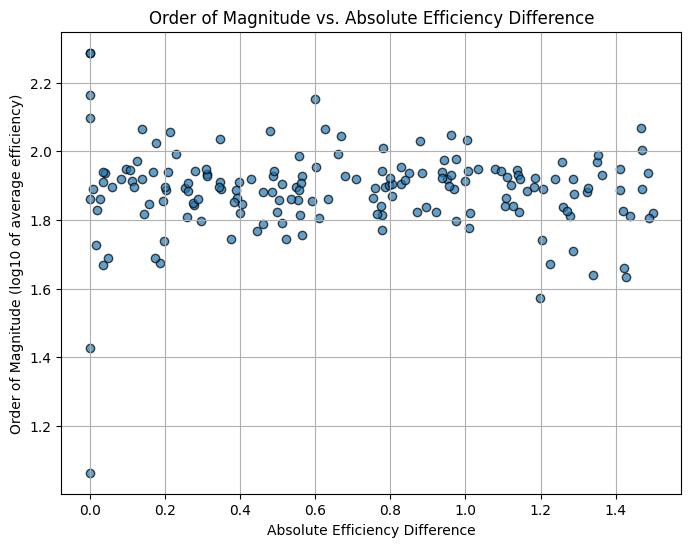

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the CSV file into a DataFrame for Range 2
df = pd.read_csv('results_csv/efficiencies_diff_range_2.csv')

# 2. Compute the average efficiency from the alfa and CL columns
df['efficiency_mean'] = (df['efficiency_alfa'] + df['efficiency_CL']) / 2.0

# 3. Compute the order of magnitude (log10) of the average efficiency
#    (Ensure that efficiency_mean > 0 to avoid issues with log10)
df = df[df['efficiency_mean'] > 0]  # Filter out any non-positive values if needed
df['eff_order'] = np.log10(df['efficiency_mean'])

# 4. Compute the absolute value of the efficiency difference
df['abs_diff'] = df['efficiency_difference'].abs()

# 5. Create a scatter plot: x-axis = absolute efficiency difference, y-axis = order of magnitude
plt.figure(figsize=(8,6))
plt.scatter(
    df['abs_diff'],    # x-axis: absolute efficiency difference
    df['eff_order'],   # y-axis: log10(average efficiency)
    alpha=0.7,
    edgecolor='k'
)

plt.xlabel('Absolute Efficiency Difference')
plt.ylabel('Order of Magnitude (log10 of average efficiency)')
plt.title('Order of Magnitude vs. Absolute Efficiency Difference')
plt.grid(True)

# 6. Show the plot
plt.show()

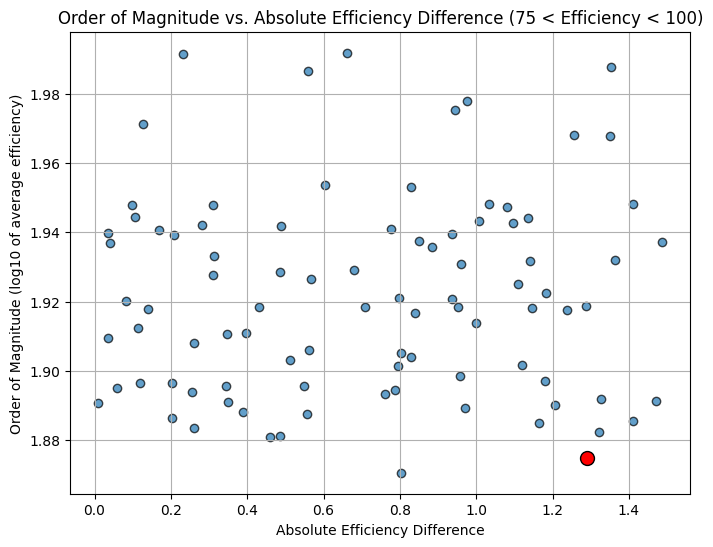

In [11]:
# 1. Load the CSV file into a DataFrame
df = pd.read_csv('results_csv/efficiencies_diff_range_2.csv')

# 2. Compute the average efficiency from the alfa and CL columns
df['efficiency_mean'] = (df['efficiency_alfa'] + df['efficiency_CL']) / 2.0

# 3. Filter to keep airfoils with 75 < efficiency_mean < 100
df = df[(df['efficiency_mean'] > 74) & (df['efficiency_mean'] < 100)]

# 4. Compute the order of magnitude (log10) of the average efficiency
df['eff_order'] = np.log10(df['efficiency_mean'])

# 5. Compute the absolute value of the efficiency difference
df['abs_diff'] = df['efficiency_difference'].abs()

# 6. Create a scatter plot for all filtered airfoils
plt.figure(figsize=(8,6))
plt.scatter(
    df['abs_diff'],    # x-axis: absolute efficiency difference
    df['eff_order'],   # y-axis: log10(average efficiency)
    alpha=0.7,
    edgecolor='k'
)

# 7. Highlight the "atr72sm.dat" reference point in red
ref_point = df[df['airfoil'] == 'atr72sm.dat']
if not ref_point.empty:
    plt.scatter(
        ref_point['abs_diff'],
        ref_point['eff_order'],
        s=100,         # larger marker size
        color='red',   # distinct color
        edgecolor='k',
        zorder=5       # ensure it appears on top
    )

# 8. Label axes and show the plot
plt.xlabel('Absolute Efficiency Difference')
plt.ylabel('Order of Magnitude (log10 of average efficiency)')
plt.title('Order of Magnitude vs. Absolute Efficiency Difference (75 < Efficiency < 100)')
plt.grid(True)
plt.show()